# Clustering

### Load data

In [1]:
import numpy as np

with open("label_file.tsv","r") as f:
    lines1 = f.read().splitlines()[1:]
with open("vec_file.tsv","r") as f:
    lines2 = f.read().splitlines()

x, label, true_sent, pred_sent = [], [], [], []
for line1,line2 in zip(lines1, lines2):
    a = line1.split("\t")
    b = line2.split("\t")
    x.append([float(bb) for bb in b])
    
    true_sent.append(a[0])
    pred_sent.append(a[1])
    label.append(a[2])
    
x = np.array(x)  


### Reduce dimension

In [2]:
# Carefully for the parameters

# # PCA 
# from sklearn.decomposition import PCA
# print("Computing PCA projection")
# x_reduced = PCA(n_components=2).fit_transform(x)


# tSNE 
from sklearn.manifold import TSNE
print("Computing tSNE projection")
x_reduced = TSNE(n_components=2, perplexity=50, learning_rate=10, init='pca').fit_transform(x)


Computing tSNE projection


### Clustering 

In [17]:
# Kmeans
from sklearn.cluster import KMeans
k = 8
print("Clustering with Kmeans")

# clustering before dim deduction
kmeans= KMeans(n_clusters=k, random_state=0, max_iter=2000).fit(x)
y_pred = kmeans.predict(x)

# # clustering after dim deduction
# kmeans = KMeans(n_clusters=k, random_state=0).fit(x_reduced)
# y_pred = kmeans.predict(x_reduced)


Clustering with Kmeans


### Check dialog acts in each cluster

In [18]:
clusters = {}
points = {}
for i in range(k):
    clusters[i] = set()
    points[i] = []

for index, clas in enumerate(y_pred):
#     clusters[clas].add(label[index])
    clusters[clas].add(true_sent[index])
#     clusters[clas].add(pred_sent[index])
    points[clas].append(index)
    
for i in range(k):
    clusters[i] = list(clusters[i])


### Visualize in Matplotlib

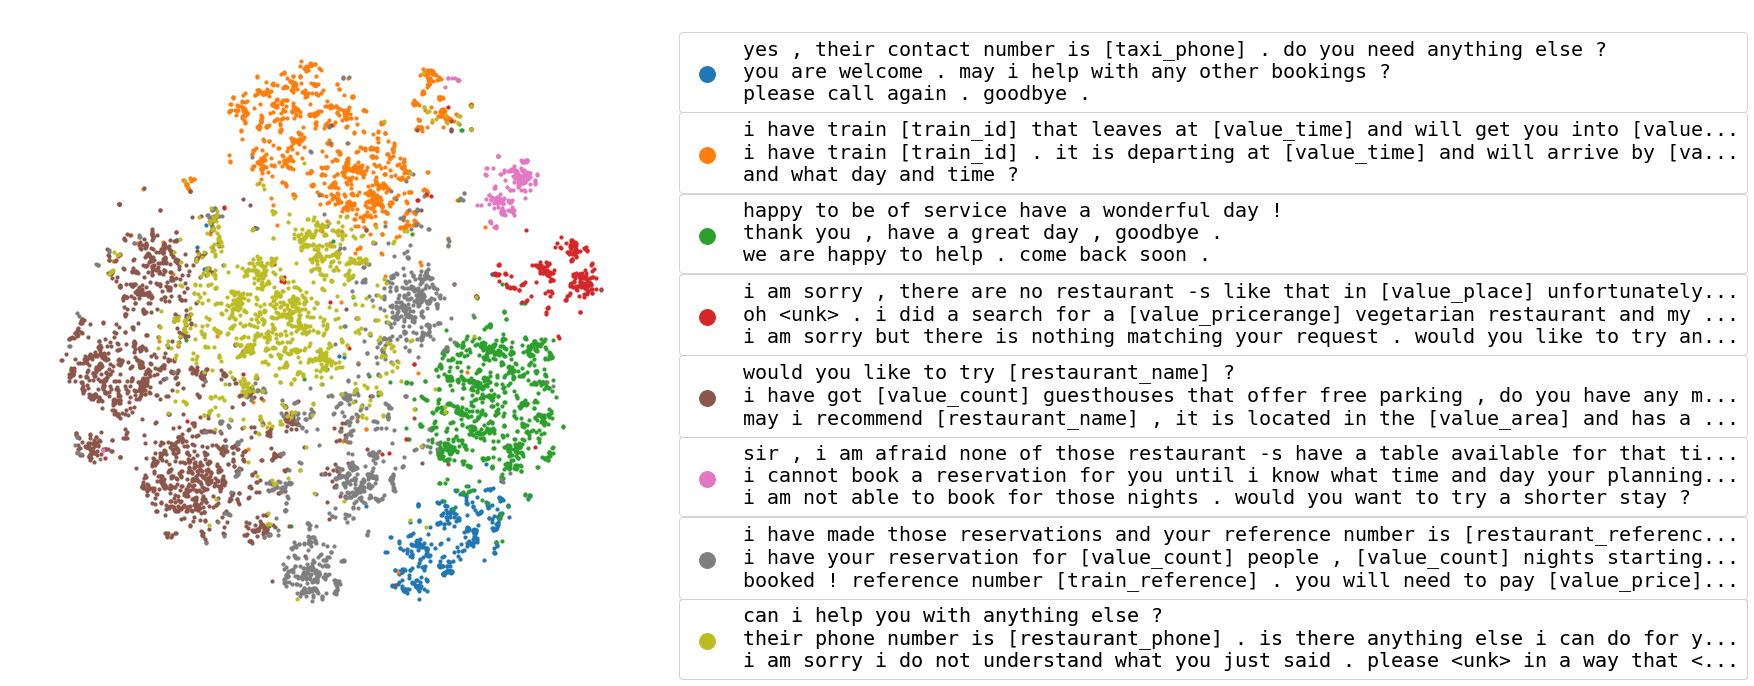

In [39]:
# Plot
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
%matplotlib inline

x_min, x_max = np.min(x_reduced, 0), np.max(x_reduced, 0)
X = (x_reduced - x_min) / (x_max - x_min) # scale the values to fit

fig, ax = plt.subplots(1, 1, figsize=(40, 10))
fig.subplots_adjust(left=0.05, bottom=0.05, top=0.95, right=0.95)

# ax.set_title(ax_name, fontsize=20)
ax.set_ylim((-0.1, 1.1))
ax.set_xlim((-0.1,1.1))

ax.set_xticks([])
ax.set_yticks([])

colors = get_cmap("tab10", k+1) # CMRmap # Set2 # Set1 # Paired

plots = []
for i in range(k):
    p = points[i]
    plot = ax.scatter(X[:, 0][p], X[:, 1][p], s=10, color=colors(i))
    plots.append(plot)

# Legend
num_show = 8
# cluster_list = [0, 2, 3, , 7]
cluster_list = range(8)
max_seq_len=80
# # Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.25, box.height])

legends = []
j = 0
for i in cluster_list:
    text = []
    for d in np.random.choice(clusters[i], 3):
        if len(d) > max_seq_len:
            sentence = d[:max_seq_len] + "..."
        else:
            sentence = d.ljust(max_seq_len+3, " ")
        text.append(sentence)
    text = "\n".join(text)
    leg = ax.legend([plots[i]], [text], loc='center right', bbox_to_anchor=(2.7, 0.9-0.125*j), ncol=1,
              fontsize=20, markerscale=5, columnspacing=0.3, 
                    handletextpad=0.8, handlelength=2.0,
                   borderpad=0.4,borderaxespad=0.5,
                   prop={"family":"monospace","size":20}) # serif monospace
    
    legends.append(leg)
    j += 1
    
for i in range(num_show):
    plt.gca().add_artist(legends[i])

ax.axis('off')
plt.savefig('../outputs/clustering.pdf', dpi=1200)
plt.show()



# Plot Training Curvers

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os

exp_name = '2.0'

BASE_DIR = './'


# Success/Match
ss, se = 0, 80
x_all, success_all, match_all, bleu_all = [], [], [], []

# hrl
metric = ["success", "match", "bleu"]
for m in metric:
    file_path = os.path.join(BASE_DIR, "hrl_%s"%exp_name,"val_%s.csv"%m)
    with open(file_path, "r") as f:
        curve = pd.read_csv(f)
        value = curve.values
        value = value[ss:se]
        x, y = value[ss:, 1], value[ss:, 2]
        x, y = np.array(x), np.array(y)*100

        if m == "success":
            x_all.append(x)
            success_all.append(y)
        elif m == "match":
            match_all.append(y)
        elif m == "bleu":
            bleu_all.append(y)      
se = len(x_all[-1]) + ss

# larl + word
models_name = ['larl', 'word']

for model_name in models_name:
    file_path = os.path.join(BASE_DIR, "%s_%s"%(model_name,exp_name), "val-rl.tsv")
    with open(file_path, "r") as f:
        lines = f.read().splitlines()
        end = min(se, len(lines))
        lines = lines[ss:end] # tricks
        s, m, x = [], [], []
        for line in lines:
            record = line.split("\t")
            x.append(int(record[0]))
            m.append(float(record[3])*100)
            s.append(float(record[2])*100)
    file_path = os.path.join(BASE_DIR, "%s_%s"%(model_name,exp_name), "val-ppl.tsv")
    with open(file_path, "r") as f:
        lines = f.read().splitlines()
        end = min(se, len(lines))
        lines = lines[ss:end] # tricks
        b = []
        for line in lines:
            record = line.split("\t")
            b.append(float(record[2])*100)           
    x_all.append(np.array(x))
    success_all.append(np.array(s)) # success
    match_all.append(np.array(m))
    bleu_all.append(np.array(b))
 
# human
x_all.append(x_all[-1])
steps = len(x_all[-1])
if exp_name == "2.0":
    success_all.append(np.array([82.7]*steps))
    match_all.append(np.array([91]*steps))
    bleu_all.append(np.array([100]*steps))

else:
    success_all.append(np.array([79.1]*steps))
    match_all.append(np.array([86.3]*steps))
    bleu_all.append(np.array([100]*steps))    

xname = 'Training Episode'
labels = ['HDNO',
          'LaRL',
          'WE2E',
          'Human'
         ]


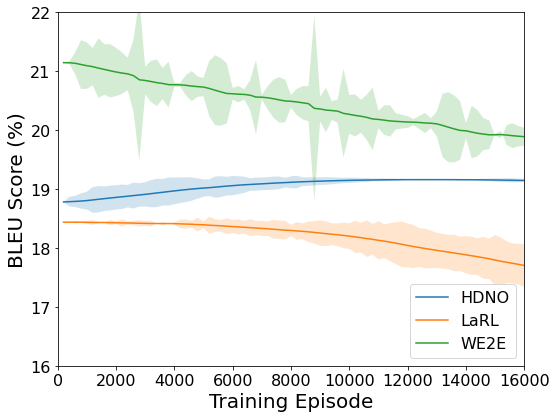

In [11]:
# plot Success
file_name = "multiwoz_%s-success"%exp_name
ax_name = "MultiWoz %s Success"%exp_name
yname = 'Success Rate (%)'
y_min, y_max = 58, 88
x_min, x_max = 0, x_all[0][-1]
weight = 0.95
variance = 0.25
alpha = 0.2
y_all = success_all

# plot Match
file_name = "multiwoz_%s-inform"%exp_name
ax_name = "MultiWoz %s Inform"%exp_name
yname = 'Inform Rate (%)'
y_min, y_max = 67, 97
x_min, x_max = 0, x_all[0][-1]
weight = 0.95
variance = 0.25
alpha = 0.2
y_all = match_all


# plot BLEU
file_name = "multiwoz_%s-bleu"%exp_name
ax_name = "MultiWoz %s BLEU"%exp_name
yname = 'BLEU Score (%)'
y_min, y_max = 16, 22
x_min, x_max = 0, x_all[0][-1]
weight = 0.99
variance = 0.2
alpha = 0.2
y_all = bleu_all


# smooth function for plots
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
    return smoothed

fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
fig.subplots_adjust(left=0.14, bottom=0.132, top=0.95, right=0.95)

# ax1.set_title(ax_name, fontsize=20)
ax1.set_xlabel(xname, fontsize=20)
ax1.set_ylabel(yname, fontsize=20)
ax1.set_ylim((y_min, y_max))
ax1.set_xlim((x_min, x_max))
ax1.tick_params(labelsize=16)


for x, y, label in zip(x_all, y_all, labels):  
    ys = smooth(y, weight)
    if label == "Human":
        if yname != 'BLEU Score (%)':
            ax1.plot(x, ys, label=label, linewidth=1.5, linestyle="--")
        else:
            pass
    else:
        ax1.plot(x, ys, label=label, linewidth=1.5)
    e = (ys - y)*variance
    ax1.fill_between(x, ys-e, ys+e, alpha=alpha)


ax1.legend(fontsize=16, loc='lower right')

plt.savefig(BASE_DIR + 'outputs/%s.pdf'%file_name, dpi=600)
            
            

In [12]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os

exp_name = '2.1'

BASE_DIR = './'


# Success/Match
ss, se = 0, 100
x_all, success_all, match_all, bleu_all = [], [], [], []

# hrl
metric = ["success", "match", "bleu"]
for m in metric:
    file_path = os.path.join(BASE_DIR, "hrl_%s"%exp_name,"val_%s.csv"%m)
    with open(file_path, "r") as f:
        curve = pd.read_csv(f)
        value = curve.values
        value = value[ss:se]
        x, y = value[ss:, 1], value[ss:, 2]
        x, y = np.array(x), np.array(y)*100

        if m == "success":
            x_all.append(x)
            success_all.append(y)
        elif m == "match":
            match_all.append(y)
        elif m == "bleu":
            bleu_all.append(y)      
se = len(x_all[-1]) + ss

# larl + word
models_name = ['larl', 'word']

for model_name in models_name:
    file_path = os.path.join(BASE_DIR, "%s_%s"%(model_name,exp_name), "val-rl.tsv")
    with open(file_path, "r") as f:
        lines = f.read().splitlines()
        end = min(se, len(lines))
        lines = lines[ss:end] # tricks
        s, m, x = [], [], []
        for line in lines:
            record = line.split("\t")
            x.append(int(record[0]))
            m.append(float(record[3])*100)
            s.append(float(record[2])*100)
    file_path = os.path.join(BASE_DIR, "%s_%s"%(model_name,exp_name), "val-ppl.tsv")
    with open(file_path, "r") as f:
        lines = f.read().splitlines()
        end = min(se, len(lines))
        lines = lines[ss:end] # tricks
        b = []
        for line in lines:
            record = line.split("\t")
            b.append(float(record[2])*100)           
    x_all.append(np.array(x))
    success_all.append(np.array(s)) # success
    match_all.append(np.array(m))
    bleu_all.append(np.array(b))
 
# human
x_all.append(x_all[-1])
steps = len(x_all[-1])
if exp_name == "2.0":
    success_all.append(np.array([82.7]*steps))
    match_all.append(np.array([91]*steps))
    bleu_all.append(np.array([100]*steps))

else:
    success_all.append(np.array([79.1]*steps))
    match_all.append(np.array([86.3]*steps))
    bleu_all.append(np.array([100]*steps))    

xname = 'Training Episode'
labels = ['HDNO',
          'LaRL',
          'WE2E',
          'Human'
         ]


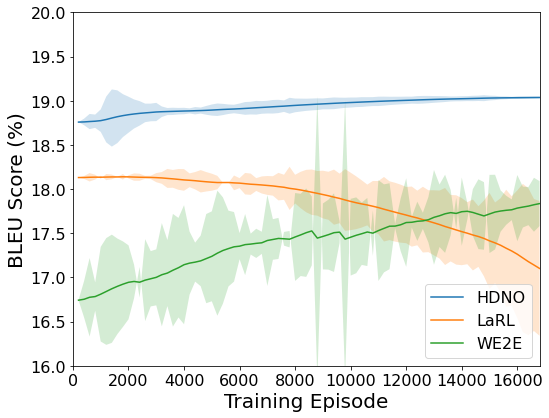

In [15]:
# plot Success
file_name = "multiwoz_%s-success"%exp_name
ax_name = "MultiWoz %s Success"%exp_name
yname = 'Success Rate (%)'
y_min, y_max = 55,85
x_min, x_max = 0, x_all[0][-1]
weight = 0.95
variance = 0.25
alpha = 0.2
y_all = success_all

# plot Match
file_name = "multiwoz_%s-inform"%exp_name
ax_name = "MultiWoz %s Inform"%exp_name
yname = 'Inform Rate (%)'
y_min, y_max = 65, 95
x_min, x_max = 0, x_all[0][-1]
weight = 0.95
variance = 0.25
alpha = 0.2
y_all = match_all


# plot BLEU
file_name = "multiwoz_%s-bleu"%exp_name
ax_name = "MultiWoz %s BLEU"%exp_name
yname = 'BLEU Score (%)'
y_min, y_max = 16, 20
x_min, x_max = 0, x_all[0][-1]
weight = 0.99
variance = 0.2
alpha = 0.2
y_all = bleu_all


# smooth function for plots
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
    return smoothed

fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
fig.subplots_adjust(left=0.14, bottom=0.132, top=0.95, right=0.95)

# ax1.set_title(ax_name, fontsize=20)
ax1.set_xlabel(xname, fontsize=20)
ax1.set_ylabel(yname, fontsize=20)
ax1.set_ylim((y_min, y_max))
ax1.set_xlim((x_min, x_max))
ax1.tick_params(labelsize=16)


for x, y, label in zip(x_all, y_all, labels):  
    ys = smooth(y, weight)
    if label == "Human":
        if yname != 'BLEU Score (%)':
            ax1.plot(x, ys, label=label, linewidth=1.5, linestyle="--")
        else:
            pass
    else:
        ax1.plot(x, ys, label=label, linewidth=1.5)
    e = (ys - y)*variance
    ax1.fill_between(x, ys-e, ys+e, alpha=alpha)


ax1.legend(fontsize=16, loc='lower right')

plt.savefig(BASE_DIR + 'outputs/%s.pdf'%file_name, dpi=600)
            
            